In [29]:
class Instrument(object):
    def __init__(self, df, timesofday, lags):
        self._raw_data = df
        self.timesofday = timesofday
        self.id = df["InstrumentID"][0]
        self.market_time, self.hour = self.get_market_time()
        self.clean_data = self.clean_data()
        self.lags = lags
        self.vols = [self.daily_vol(lag) for lag in self.lags]
        self._reset_cache()
        
    def clean_data(self):
        """Clean dataframe"""
        df = self._raw_data
        df["UpdateTime"] = df["UpdateTime"].apply(lambda x: parse(x).time())  
        # select data within makert time
        mask = pd.Series(np.zeros(len(df))).astype(bool)
        for period in self.market_time:
            mask = np.logical_or(mask, np.logical_and(df["UpdateTime"] >= period[0], df["UpdateTime"] <= period[1]))
        return df[mask]
        
    def get_market_time(self):
        """Create a dataframe with maket open periods"""
        df = pd.DataFrame(index = ["ag", "bu", "rb", "ru", "zn"],
                          columns = ["day_period_1", "day_period_2", "day_period_3", "night_period_1"])
        df.index.name = "Instrument"
        df.columns.name = "open periods"
        for row in df.index:
            df.loc[row]["day_period_1"] = (dt.time(9, 0, 0), dt.time(10, 15, 0))
            df.loc[row]["day_period_2"] = (dt.time(10, 30, 0), dt.time(11, 30, 0))
            df.loc[row]["day_period_3"] = (dt.time(13, 30, 0), dt.time(15, 0, 0))
        for row in "ag", :
            df.loc[row]["night_period_1"] = (dt.time(21, 0, 0), dt.time(2, 30, 0))
        for row in "bu", "rb", "zn":
            df.loc[row]["night_period_1"] = (dt.time(21, 0, 0), dt.time(1, 0, 0))
        for row in "ru", :
            df.loc[row]["night_period_1"] = (dt.time(21, 0, 0), dt.time(11, 0, 0))
        market_time = df.loc[self.id[:2]]
        if self.timesofday == "day":
            market_time = market_time[:3]
        else:
            market_time = market_time[-1:]
        hour = 0
        for period in market_time:
            dum = (period[1].hour - period[0].hour) + (period[1].minute - period[0].minute) / 60.0
            hour += dum if dum > 0 else (dum + 24)
        return market_time, hour
    
    def daily_vol(self, k = 1):
        """Calculate volatility for dataframe
        Inputs:
                df: dataframe, raw data of commodity futures price in a day
                k: int, lag used to calculate volatility
        Outputs:
                vol: float, volatility of the dataframe
        """

        s = self.clean_data["LastPrice"].apply(np.log)
        x = (s - s.shift(k)).dropna()
        vol_squared = (np.sum(x * x) + np.sum((x * x.shift(-k)).dropna()) + np.sum((x * x.shift(k)).dropna())) / k
        vol_squared = max(0, vol_squared)      # vol_squared could be negative 
        vol = np.sqrt(vol_squared / self.hour * 24 * 252)
        return vol
    
    def to_dict(self):
        data_dict = {"timesofday": self.timesofday, "instrument_id": self.id, 
                     "min_vol_lag": self.lags[np.argmin(self.vols)], 
                     "max_vol_lag": self.lags[np.argmax(self.vols)]}
        for i, lag in enumerate(self.lags):
            data_dict["vol_" + repr(lag)] = self.vols[i]
        return data_dict
    def _reset_cache(self):
        self._raw_data = None
        self.clean_data = None

In [30]:
import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from dateutil.parser import parse
import pdb
import seaborn as sns
from tqdm import tqdm

commodities = [name for name in os.listdir(config.DATA_BASE_PATH) if not name.startswith(".")] 
timesofdays = ["day", "night"]
lags = range(1, 20)

for commodity in commodities[0], :
    for timesofday in timesofdays[0], :
        timesofday_path = os.path.join(config.DATA_BASE_PATH, commodity, timesofday)
        timesofday_files = os.listdir(timesofday_path)
        data = []
        for i, timesofday_file in enumerate(tqdm(timesofday_files)) :
            timesofday_df = pd.read_csv(os.path.join(timesofday_path, timesofday_file))
            if not timesofday_df.empty:
                inst = Instrument(timesofday_df, timesofday, lags)
                data.append(inst.to_dict())
            else:
                print(timesofday_file)
        vol_df = pd.DataFrame(data)

  9%|▊         | 249/2928 [01:08<1:02:37,  1.40s/it]

ag1606_20160114.csv


100%|██████████| 2928/2928 [27:56<00:00,  1.81it/s]  


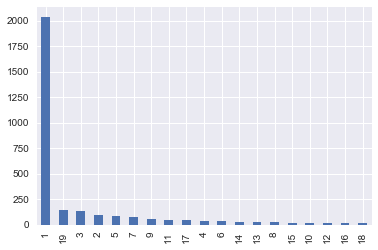

In [31]:
vol_df["max_vol_lag"].value_counts().plot(kind='bar')
plt.savefig(os.path.join(config.OUTPUT_PATH, "max_vol_lag.png"), dpi = 1000)

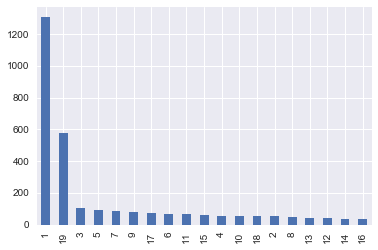

In [32]:
vol_df["min_vol_lag"].value_counts().plot(kind='bar')
plt.savefig(os.path.join(config.OUTPUT_PATH, "min_vol_lag.png"), dpi = 1000)